In [1]:
# Based on the data preprocessign from: 
# https://mne.tools/stable/auto_examples/decoding/decoding_csp_eeg.html#sphx-glr-auto-examples-decoding-decoding-csp-eeg-py

In [2]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 46.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

In [34]:
tmin, tmax = -1., 4.
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

In [35]:
raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)

Using default location ~/mne_data for EEGBCI...
Creating ~/mne_data


Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json


Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.4 MB, data loaded>

In [36]:
# Apply band-pass filter
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Used Annotations descriptions: ['T1', 'T2']


In [70]:
# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1] - 2
epochs_data = epochs.get_data()

Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped


In [76]:
class Classification:

    def __init__(self, num_classes):
        # the classifier elements: lda and csp
        self.csp = CSP(n_components=num_classes, reg=None, log=True, norm_trace=False)
        self.lda = LinearDiscriminantAnalysis()

    def train(self, X, y):
        transformed_data = self.csp.fit_transform(X, y)
        self.lda.fit(transformed_data, y)
    
    def predict(self, X):
        transformed_data = self.csp.transform(X)
        return self.lda.predict(transformed_data)
    
    def return_csp(self, X):
        return self.csp.transform(X)
    
    def plot_cps(self, epochs):
        self.csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

In [77]:
classifier = Classification(4)

In [78]:
classifier.train(epochs_data, labels)

Computing rank from data with rank=None
    Using tolerance 0.00025 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00026 (2.2e-16 eps * 64 dim * 1.9e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


In [79]:
preds = classifier.predict(epochs_data)

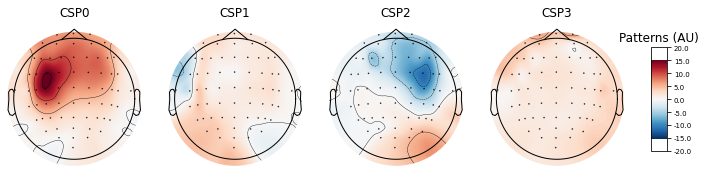

In [80]:
classifier.plot_cps(epochs)

In [81]:
# calculate accuracy
from sklearn.metrics import accuracy_score

accuracy_score(labels, preds)

0.9555555555555556